In [81]:
!git clone https://github.com/YasirHabib/The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning.git

fatal: destination path 'The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning' already exists and is not an empty directory.


In [82]:
!ls The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import ntpath

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [0]:
path = 'The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data'
train_dir = os.path.join(path, 'driving_log.csv')

In [86]:
df_data = pd.read_csv(train_dir, header = None)
df_data.head()

,0,1,2,3,4,5,6
0,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_292.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_292.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_292.jpg,0.0,0.0,0.0,0.000081
1,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_402.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_402.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_402.jpg,0.0,0.0,0.0,0.000078
2,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_508.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_508.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_508.jpg,0.0,0.0,0.0,0.000078
3,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_609.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_609.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_609.jpg,0.0,0.0,0.0,0.000078
4,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_718.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_718.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_718.jpg,0.0,0.0,0.0,0.000082


In [87]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df_data = pd.read_csv(train_dir, names = columns)
df_data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_292.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_292.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_292.jpg,0.0,0.0,0.0,0.000081
1,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_402.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_402.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_402.jpg,0.0,0.0,0.0,0.000078
2,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_508.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_508.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_508.jpg,0.0,0.0,0.0,0.000078
3,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_609.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_609.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_609.jpg,0.0,0.0,0.0,0.000078
4,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\center_2019_11_30_13_10_08_718.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\left_2019_11_30_13_10_08_718.jpg,C:\Laptop\GitHub\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning\Data\IMG\right_2019_11_30_13_10_08_718.jpg,0.0,0.0,0.0,0.000082


In [88]:
def path_split(path):
  head, tail = ntpath.split(path)
  return tail

df_data['center'] = df_data['center'].apply(path_split)
df_data['left'] = df_data['left'].apply(path_split)
df_data['right'] = df_data['right'].apply(path_split)

df_data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_11_30_13_10_08_292.jpg,left_2019_11_30_13_10_08_292.jpg,right_2019_11_30_13_10_08_292.jpg,0.0,0.0,0.0,0.000081
1,center_2019_11_30_13_10_08_402.jpg,left_2019_11_30_13_10_08_402.jpg,right_2019_11_30_13_10_08_402.jpg,0.0,0.0,0.0,0.000078
2,center_2019_11_30_13_10_08_508.jpg,left_2019_11_30_13_10_08_508.jpg,right_2019_11_30_13_10_08_508.jpg,0.0,0.0,0.0,0.000078
3,center_2019_11_30_13_10_08_609.jpg,left_2019_11_30_13_10_08_609.jpg,right_2019_11_30_13_10_08_609.jpg,0.0,0.0,0.0,0.000078
4,center_2019_11_30_13_10_08_718.jpg,left_2019_11_30_13_10_08_718.jpg,right_2019_11_30_13_10_08_718.jpg,0.0,0.0,0.0,0.000082


[ 130    6    1   17   74   17    3   23  323   49    2   63 3612   42
    0   19  163   34    1   16   42   20    1    0   81] [-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


<BarContainer object of 25 artists>

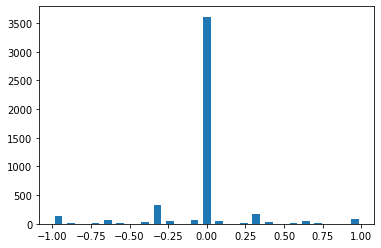

In [99]:
num_bins = 25
hist, bins = np.histogram(df_data['steering'], num_bins)
print(hist, bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)